<a href="https://colab.research.google.com/github/erzar0/engineering-thesis/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import numpy as np

npz = np.load('/content/drive/MyDrive/thesis/Gasecki/Gasecki_data_corr_total.npz', allow_pickle=True)
gasecki_e_xy = npz["E_xy"]

npz = np.load('/content/drive/MyDrive/thesis/Sobieski/Sobieski_data_corr_total.npz', allow_pickle=True)
sobieski_e_xy = npz["E_xy"]

npz = np.load('/content/drive/MyDrive/thesis/Matka_Boska/Matka_Boska_data_corr_total_Cu.npz', allow_pickle=True)
matka_boska_e_xy = npz["E_xy"]

npz = np.load('/content/drive/MyDrive/thesis/Blank_PcbCu/GEM_Cr_PBS1_Blank_PcbCu_ArCO2_75_25_Gain_35_Thr_35_HV_3640_Xray_50kV_04mA_part_001_GainCorr.pcap.dat.npz', allow_pickle=True)
copper_plate_e_xy = npz["E_xy"]

In [ ]:
print(sobieski_e_xy.shape)

(524, 348, 4094)


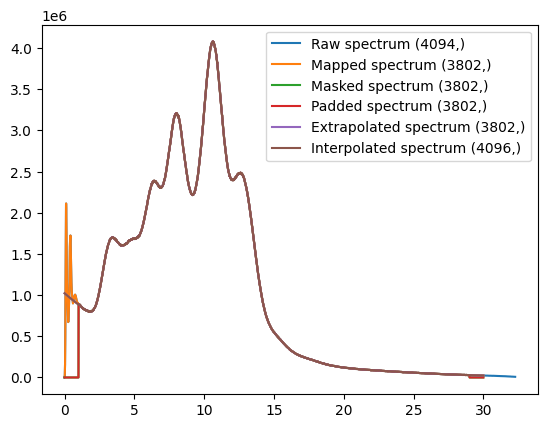

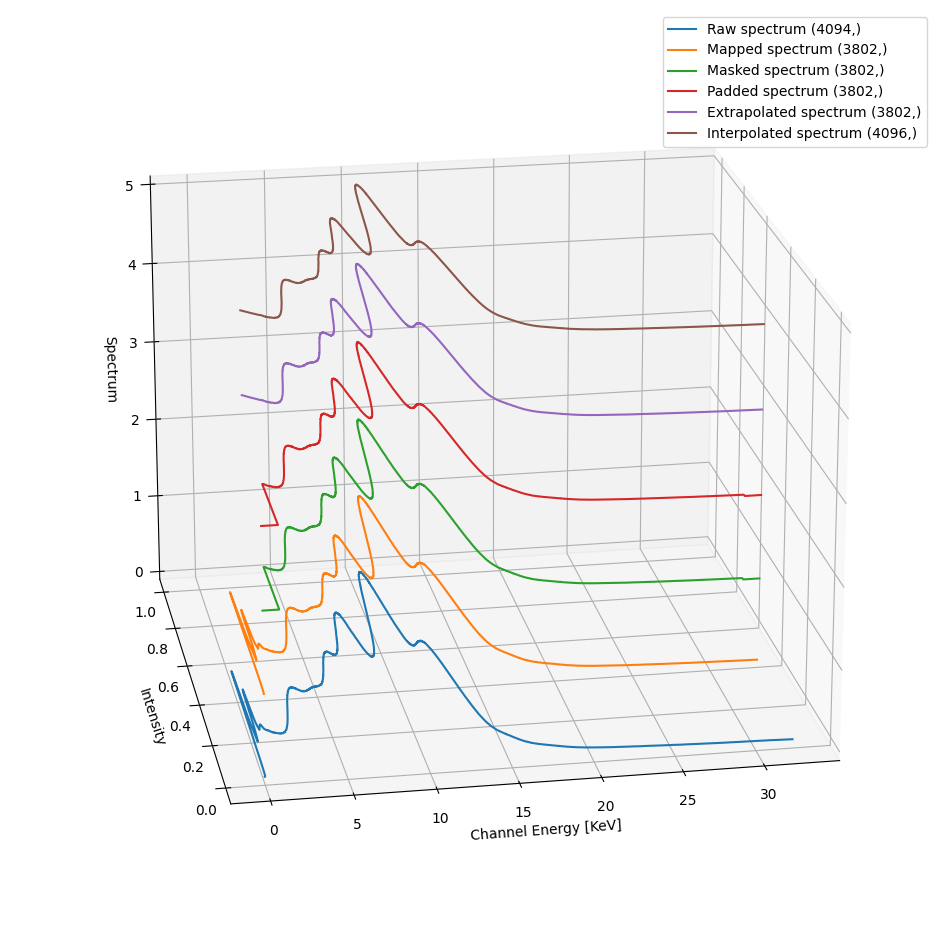

In [ ]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_processed_spectrum(e_xy, peaks, energies, min_energy=0, max_energy=30
               , energy_margin=1, target_length=4096, points_to_extrapolate_count=100
               , plot=False):
    # Calculate channel to energy mapping
    correction_coefficients = np.polyfit(peaks, energies, 1)
    channel_energies = np.poly1d(correction_coefficients)(np.arange(e_xy.shape[-1]))

    spectrum_acc = np.sum(e_xy, (0,1), dtype=np.uint32)

    # Fit spectrum in range [min_energy, max_energy]
    mask = (channel_energies >= min_energy) & (channel_energies <= max_energy)
    channel_energies_mapped = channel_energies[mask]
    spectrum_acc_mapped = spectrum_acc[mask]

    # Mask edges of spectrum by energy_margin, as they have lots of noise
    energy_margin = (channel_energies_mapped < (channel_energies_mapped[0] + energy_margin)) | (channel_energies_mapped > channel_energies_mapped[-1] - energy_margin)
    spectrum_acc_masked = spectrum_acc_mapped.copy()
    spectrum_acc_masked[energy_margin] = 0

    # Padd spectrum to the right to make sure that it fills entire energy range [min_energy, max_energy]
    step_size = channel_energies_mapped[1] - channel_energies_mapped[0]
    step_count = int((max_energy - channel_energies_mapped[-1]) // step_size)
    channel_energies_extrapolated = np.concatenate((channel_energies_mapped, np.linspace(channel_energies_mapped[-1], max_energy, step_count)))
    spectrum_acc_padded = np.concatenate((spectrum_acc_masked, np.zeros(step_count)))

    # Extrapolate masked start of spectrum
    def exponential_function(x, a, b):
        return a * np.exp(b * x)

    spectrum_acc_extrapolated = spectrum_acc_padded.copy()
    non_zero_start_idx = np.where((spectrum_acc_padded == 0) & (np.arange(len(spectrum_acc_padded)) < 1000))[0][-1] + 1
    params, covariance = curve_fit(exponential_function
                                   , channel_energies_extrapolated[non_zero_start_idx:non_zero_start_idx + points_to_extrapolate_count]
                                   , spectrum_acc_padded[non_zero_start_idx:non_zero_start_idx + points_to_extrapolate_count]
                                   , maxfev=2000)
    y_extrapolate = exponential_function(channel_energies_extrapolated[:non_zero_start_idx], *params)
    spectrum_acc_extrapolated[:non_zero_start_idx] = y_extrapolate

    # Extrapolate masked end of spectrum
    non_zero_end_idx = np.where((spectrum_acc_padded == 0) & (np.arange(len(spectrum_acc_padded)) > 1000))[0][0]
    params, covariance = curve_fit(exponential_function
                                   , channel_energies_extrapolated[non_zero_end_idx - points_to_extrapolate_count:non_zero_end_idx]
                                   , spectrum_acc_padded[non_zero_end_idx - points_to_extrapolate_count:non_zero_end_idx]
                                   , maxfev=2000)
    y_extrapolate = exponential_function(channel_energies_extrapolated[non_zero_end_idx:], *params)
    spectrum_acc_extrapolated[non_zero_end_idx:] = y_extrapolate

    # Interpolate to achieve target_length, so it could be processed by neural network
    min_energy = channel_energies_extrapolated[0]
    max_energy = channel_energies_extrapolated[-1]
    channel_energies_interpolated = interp1d(channel_energies_extrapolated, channel_energies_extrapolated, fill_value="extrapolate")(np.linspace(min_energy, max_energy, target_length))
    spectrum_acc_interpolated = interp1d(channel_energies_extrapolated, spectrum_acc_extrapolated, fill_value="extrapolate")(np.linspace(min_energy, max_energy, target_length))


    if plot:
        # Plotting 2D plot
        plt.figure(2)
        plt.plot(channel_energies, spectrum_acc, label=f"Raw spectrum {spectrum_acc.shape}")
        plt.plot(channel_energies_mapped, spectrum_acc_mapped, label=f"Mapped spectrum {spectrum_acc_mapped.shape}")
        plt.plot(channel_energies_mapped, spectrum_acc_masked, label=f"Masked spectrum {spectrum_acc_masked.shape}")
        plt.plot(channel_energies_extrapolated, spectrum_acc_padded, label=f"Padded spectrum {spectrum_acc_padded.shape}")
        plt.plot(channel_energies_extrapolated, spectrum_acc_extrapolated, label=f"Extrapolated spectrum {spectrum_acc_extrapolated.shape}")
        plt.plot(channel_energies_interpolated, spectrum_acc_interpolated, label=f"Interpolated spectrum {spectrum_acc_interpolated.shape}")
        plt.legend()

        # Plotting the 3D series of 2D plots
        fig = plt.figure(3, figsize=(12, 12))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(channel_energies, spectrum_acc / np.max(spectrum_acc), zs=0, label=f"Raw spectrum {spectrum_acc.shape}")
        ax.plot(channel_energies_mapped, spectrum_acc_mapped / np.max(spectrum_acc_mapped), zs=1, label=f"Mapped spectrum {spectrum_acc_mapped.shape}")
        ax.plot(channel_energies_mapped, spectrum_acc_masked / np.max(spectrum_acc_masked), zs=2, label=f"Masked spectrum {spectrum_acc_masked.shape}")
        ax.plot(channel_energies_extrapolated, spectrum_acc_padded / np.max(spectrum_acc_padded), zs=3, label=f"Padded spectrum {spectrum_acc_padded.shape}")
        ax.plot(channel_energies_extrapolated, spectrum_acc_extrapolated / np.max(spectrum_acc_extrapolated), zs=4, label=f"Extrapolated spectrum {spectrum_acc_extrapolated.shape}")
        ax.plot(channel_energies_interpolated, spectrum_acc_interpolated / np.max(spectrum_acc_interpolated), zs=5, label=f"Interpolated spectrum {spectrum_acc_interpolated.shape}")
        ax.set_xlabel('Channel Energy [KeV]')
        ax.set_ylabel('Intensity')
        ax.set_zlabel('Spectrum')
        ax.view_init(elev=20, azim=260)
        ax.legend()
        plt.savefig("spectrum_preprocessing.svg")
        plt.show()

    return channel_energies_interpolated, spectrum_acc_interpolated

peaks_sobieski = [817, 1016,1347, 1598]
energies_sobieski = [6.405, 8.046, 10.551, 12.614]
channel_energies, spectrum_acc= get_processed_spectrum(sobieski_e_xy, peaks_sobieski, energies_sobieski, plot=True)

peaks_copper_plate = [720, 985, 1594, 2068]
energies_copper_plate = [3.692, 5.088, 8.046, 10.551]

# channel_energies, spectrum_acc = get_processed_spectrum(copper_plate_e_xy, peaks_copper_plate, energies_copper_plate, plot=True)
spectrum_acc = spectrum_acc / np.max(spectrum_acc)

np.save("copper_pcb_preprocessed_spectrum.npy", spectrum_acc)


"Copper plate" mean photon count: 424.95355224609375
"Copper plate" standard deviation of photon count: 143.14790594655412
"Gąsecki" mean photon count: 19803.944027263424
"Gąsecki" standard deviation of photon count: 4462.003004178814
"Sobieski" mean photon count: 22649.877233587584
"Sobieski" standard deviation of photon count: 3373.4751935949807
"Matka Boska" mean photon count: 20041.49389312298
"Matka Boska" standard deviation of photon count: 7218.857637285761


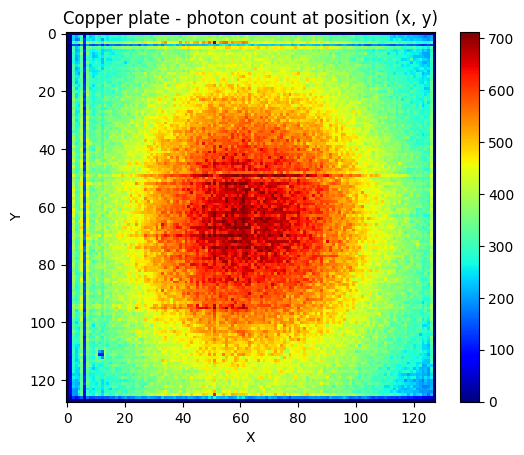

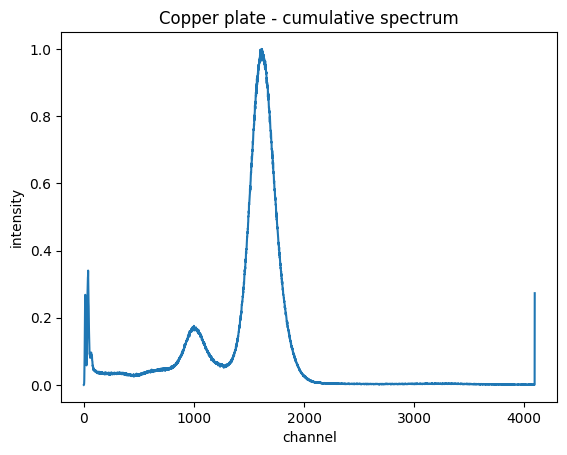

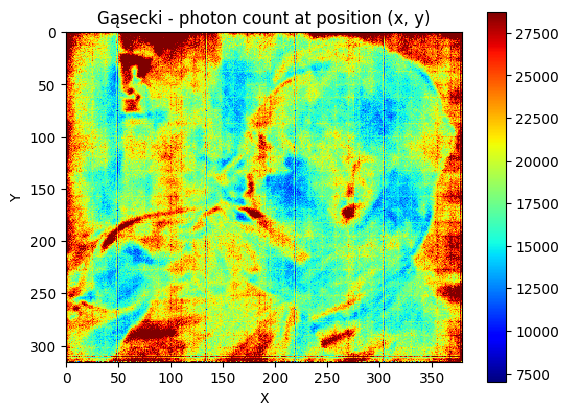

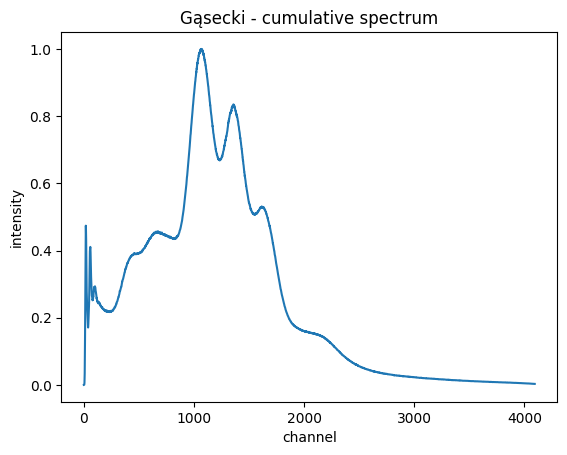

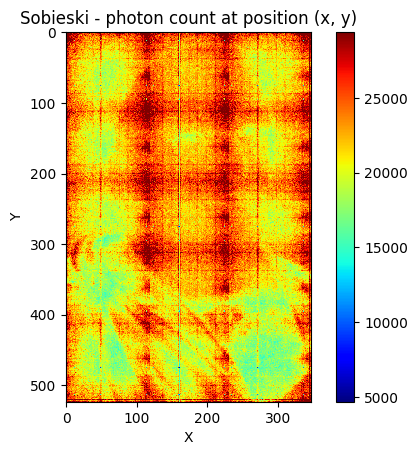

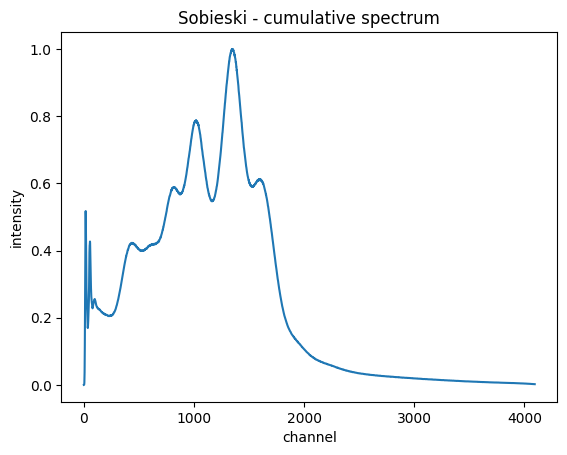

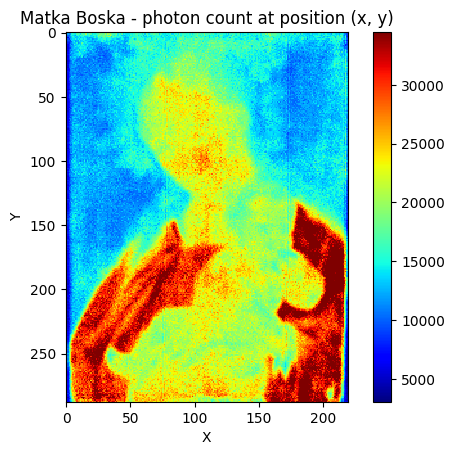

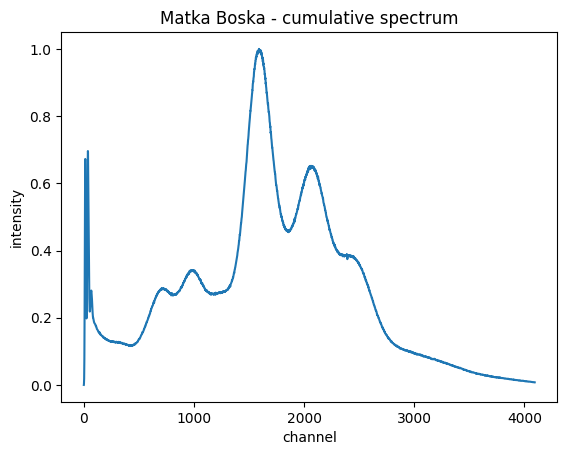

In [ ]:
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter

def show_stats(measurement, name=None):
    measurement_photon_count = np.sum(measurement, axis=-1)

    mu = np.mean(measurement_photon_count)
    sigma = np.var(measurement_photon_count)**0.5
    print(f"\"{name}\" mean photon count: {mu}")
    print(f"\"{name}\" standard deviation of photon count: {sigma}")

    plt.figure(random.randint(1, 10e10))
    plt.imshow(measurement_photon_count, cmap='jet', interpolation='nearest', vmax=mu + 2 * sigma)
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"{name} - photon count at position (x, y)")
    plt.savefig(f"{name}_photon_count.svg")

    cumulative_spectrum = np.sum(measurement, (0, 1))
    cumulative_spectrum = cumulative_spectrum / np.max(cumulative_spectrum)
    plt.figure(random.randint(1, 10e10))
    plt.xlabel("channel")
    plt.ylabel("intensity")
    plt.title(f"{name} - cumulative spectrum")
    plt.plot(cumulative_spectrum)

show_stats(copper_plate_e_xy, name="Copper plate")
show_stats(gasecki_e_xy, name="Gąsecki")
show_stats(sobieski_e_xy, name="Sobieski")
show_stats(matka_boska_e_xy, name="Matka Boska")

0.967284536276741 8.21810008231092 0.415811611236828
0.4325438097849639


5.876771062009966

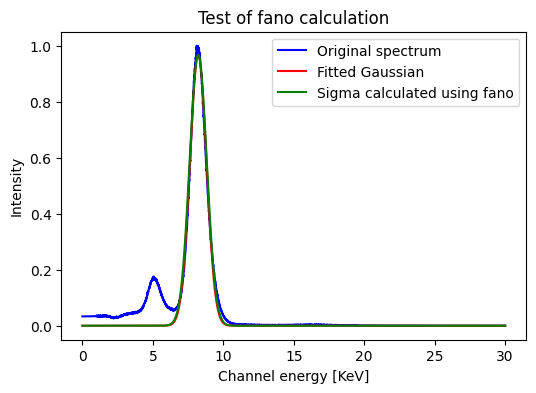

In [ ]:
from scipy.optimize import curve_fit

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / (2 * stddev))**2)

def calculate_fano(spectrum):
    x_values = np.linspace(0, 30, len(spectrum))
    (amplitude_opt, mean_opt, stddev_opt), _ = curve_fit(gaussian, x_values, spectrum)

    fitted_curve = gaussian(x_values, amplitude_opt, mean_opt, stddev_opt)

    fwhm = 2.354 * stddev_opt
    fano = ( fwhm**2 ) / (mean_opt * 2.354**2 * 0.00358 )
    sigma_calculated_with_fano = np.sqrt((0.08/2.354)**2 + 0.00385 * fano * mean_opt)

    plt.figure(figsize=(6, 4))
    plt.title("Test of fano calculation")
    plt.xlabel("Channel energy [KeV]")
    plt.ylabel("Intensity")
    plt.plot(x_values, spectrum, label='Original spectrum', color='blue')
    plt.plot(x_values, fitted_curve, label='Fitted Gaussian', color='red')
    plt.plot(x_values, gaussian(x_values, amplitude_opt, mean_opt, sigma_calculated_with_fano), label="Sigma calculated using fano", color="green")
    plt.legend()
    plt.savefig("fano_calculation.svg")
    print(amplitude_opt, mean_opt, stddev_opt)
    print(sigma_calculated_with_fano)

    plt.legend()

    return fano

calculate_fano(spectrum_acc)

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

class SelfOrganizingMap:
    def __init__(self, input_size, map_size, learning_rate=0.1, sigma_neigh=1.0, sigma_decay=1.0):
        self.input_size = input_size
        self.map_size = map_size
        self.learning_rate = learning_rate
        self.sigma_neigh = sigma_neigh
        self.sigma_decay = sigma_decay

        self.weights = np.random.rand(map_size[0], map_size[1], input_size)

    def train(self, data, epochs):
        for epoch in tqdm(range(epochs)):
            for input_vector in data:
                bmu_coords = self.find_bmu(input_vector)
                self.update_weights(input_vector, bmu_coords, epoch)

    def find_bmu(self, input_vector):
        distances = np.zeros((self.map_size[0], self.map_size[1]))
        for i in range(self.map_size[0]):
            for j in range(self.map_size[1]):
                distances[i, j] = np.linalg.norm(input_vector - self.weights[i, j])
        bmu_coords = np.unravel_index(np.argmin(distances), distances.shape)
        return bmu_coords

    def update_weights(self, input_vector, bmu_coords, iteration):
        def _alpha(iteration):
            decay_factor = np.exp(-iteration / self.sigma_decay)
            return self.learning_rate * decay_factor

        def _theta(bmu_coords, neigh_coords):
                return np.exp(-((neigh_coords[0] - bmu_coords[0])**2 + (neigh_coords[1] - bmu_coords[1])**2) / (2 * (self.sigma_neigh**2)))

        alpha = _alpha(iteration)
        for i in range(self.map_size[0]):
            for j in range(self.map_size[1]):
                updated = alpha * _theta(bmu_coords, (i, j)) * (input_vector - self.weights[i, j])
                self.weights[i, j] += updated

In [ ]:
def get_som_clustered_labels(e_xy, epochs=10, map_size=(3,3), learning_rate=0.1, sigma_neigh=0.5, sigma_decay=0.5):
    e_xy_flat= e_xy.reshape(-1, e_xy.shape[-1])
    e_xy_max_channel_counts = np.max(np.abs(e_xy_flat), axis=1, keepdims=True)
    e_xy_flat_normalized = e_xy_flat/ e_xy_max_channel_counts
    som = SelfOrganizingMap(input_size=e_xy.shape[-1], map_size=map_size, learning_rate=learning_rate, sigma_neigh=sigma_neigh, sigma_decay=sigma_decay)
    som.train(e_xy_flat_normalized, epochs)
    bmus = [[som.find_bmu(e_xy_flat_normalized[i * e_xy.shape[1] + j]) for j in range(e_xy.shape[1])] for i in range(e_xy.shape[0])]
    labels = [[bmu[0] * map_size[1] + bmu[1] for bmu in bmus_row] for bmus_row in bmus]
    return labels



In [ ]:
e_xy = matka_boska_e_xy[:, :, 100:-100]

In [ ]:
labels = get_som_clustered_labels(e_xy)

100%|██████████| 10/10 [02:16<00:00, 13.64s/it]


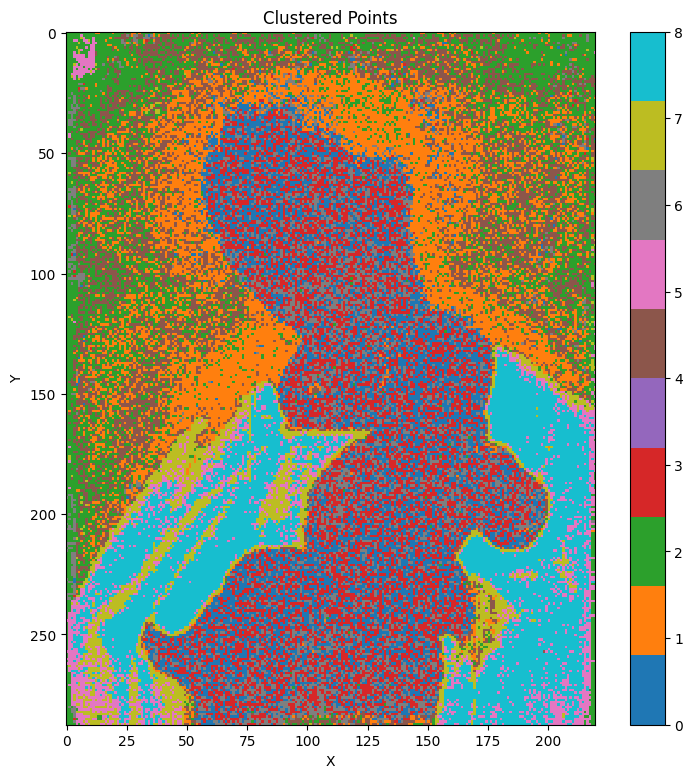

In [ ]:
plt.figure(figsize=(9,9))
plt.imshow(labels, cmap="tab10", interpolation='nearest')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clustered Points')

plt.savefig("sobieski_clustered_som_noise.svg", bbox_inches='tight', pad_inches=0.1)

In [ ]:
def get_measurement_mask(measurement, labels, label):
    mask = np.zeros(measurement.shape[:-1], dtype=bool)
    mask [np.array(labels).reshape(measurement.shape[:-1]) == label] = True
    return mask

In [ ]:
def get_label_masks(e_xy, labels, plot=True):
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    grid_size = int(np.ceil(np.sqrt(num_labels)))
    label_masks = {}
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(9,15))
    plt.subplots_adjust(wspace=0.1, hspace=-0.15)
    for i in range(grid_size):
        for j in range(grid_size):
            label = i * grid_size + j
            if label < num_labels:
                label_mask = get_measurement_mask(e_xy, labels, unique_labels[label])
                label_masks[label] = label_mask
                ax[i][j].imshow(label_mask, cmap='viridis')
                ax[i][j].set_title(f'Cluster {unique_labels[i * grid_size + j]}')
                ax[i][j].axis('off')
            else:
                fig.delaxes(ax[i][j])
    fig.savefig("sobieski_clusters_hdbscan_clean.svg", bbox_inches='tight', pad_inches=0.1)
    return label_masks


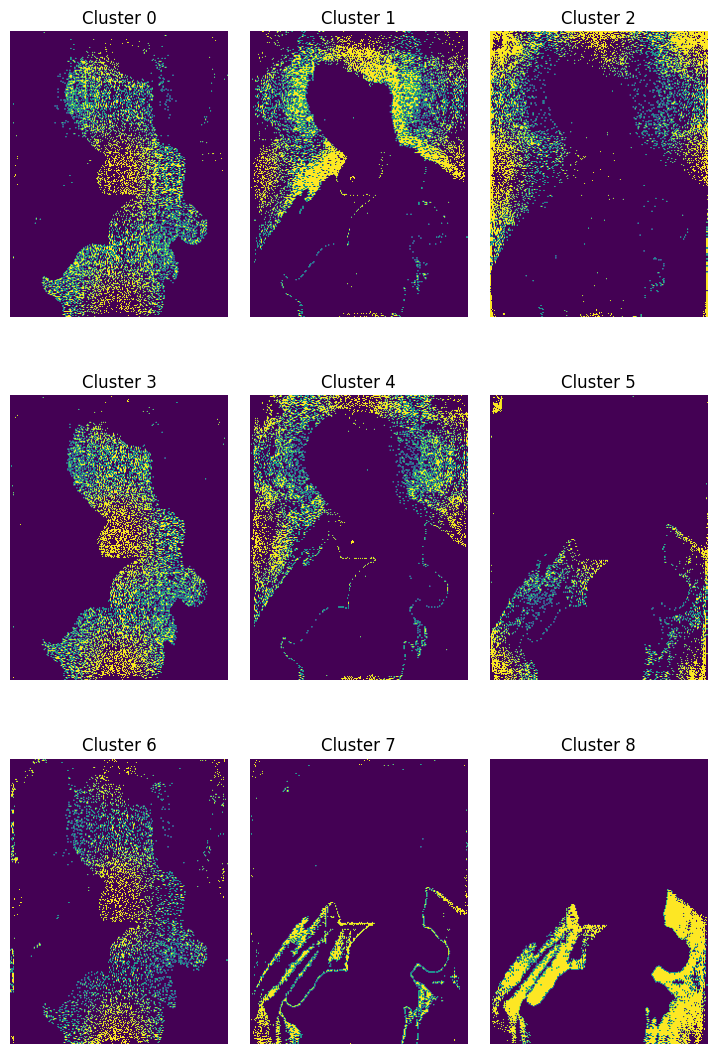

In [ ]:
label_masks = get_label_masks(e_xy, labels)

In [ ]:
def plot_clustered_spectra(e_xy, label_masks, labels, peaks, energies):
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    grid_size = int(np.ceil(np.sqrt(num_labels)))
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    for i in range(grid_size):
        for j in range(grid_size):
            label = i * grid_size + j
            if label in label_masks.keys():
                mask = label_masks[label]
                energy = e_xy * mask[:, :, np.newaxis]
                channel_energies, spectrum_acc = get_processed_spectrum(energy, peaks, energies_sobieski)

                ax[i][j].plot(channel_energies, spectrum_acc / np.max(spectrum_acc), label=f"Cluster {label}")
                ax[i][j].set_xlabel("Photon energy [KeV]")
                ax[i][j].set_ylabel("Intensity")
                ax[i][j].set_title(f'Spectrum of cluster {label}')
            else:
                fig.delaxes(ax[i][j])
    fig.savefig("sobieski_spectra_hdbscan_clean.svg", bbox_inches='tight', pad_inches=0.1)



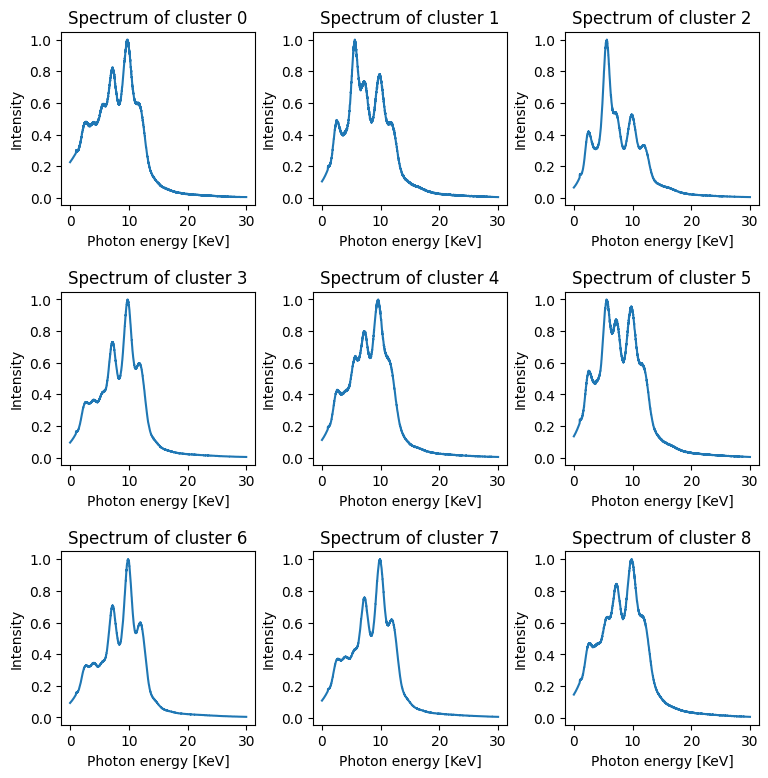

In [ ]:
peaks_sobieski = [817, 1016,1347, 1598]
energies_sobieski = [6.405, 8.046, 10.551, 12.614]
plot_clustered_spectra(sobieski_e_xy, label_masks, labels, peaks_sobieski, energies_sobieski)

In [ ]:
!pip install hdbscan
!pip install umap-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039276 sha256=dc2f4ca8403a940d1ef35091daa9aaecd29845deed2811b1553e5aba4ba8fa37
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.7
    Uninstalling Cython-3.0.7:
      Successfully uninstalled Cython-3.0.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.3 MB/s eta 0:00:00
  Created wh

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import gc
gc.collect()

e_xy_flat= e_xy.reshape(-1, e_xy.shape[-1])
e_xy_max_channel_counts = np.max(np.abs(e_xy_flat), axis=1, keepdims=True)
e_xy_flat_normalized = e_xy_flat/ e_xy_max_channel_counts

clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=1
).fit_transform(e_xy_flat_normalized)

In [ ]:
import hdbscan
from sklearn.cluster import HDBSCAN

clusterable_embedding = clusterable_embedding.reshape(e_xy_flat.shape[0], 1)

labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=2500,
    metric='l2'
).fit_predict(clusterable_embedding) + 1

[0 1 2 3 4 5 6 7 8 9]


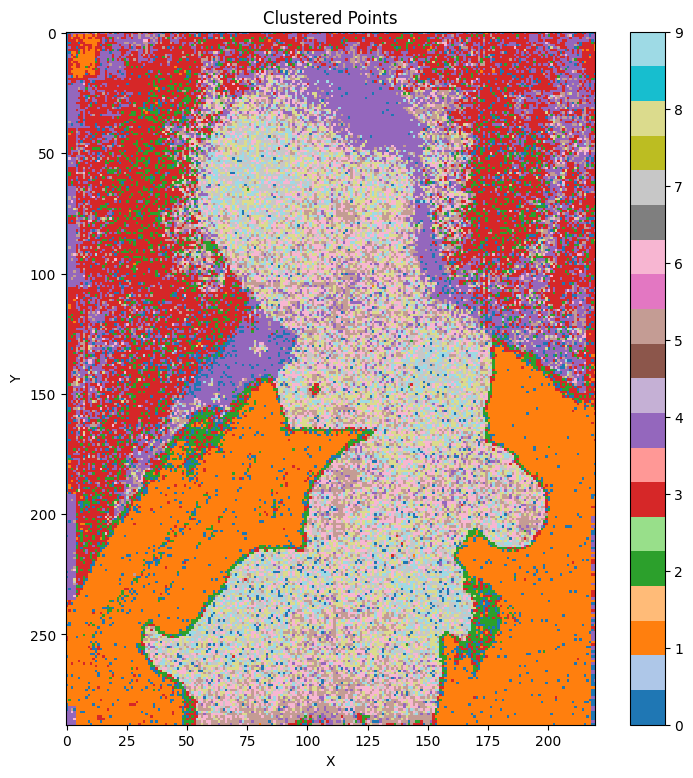

In [ ]:
plt.figure(figsize=(9,9))
plt.imshow(labels.reshape(*e_xy.shape[:-1]), cmap="tab20", interpolation="nearest")
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clustered Points')
plt.savefig("sobieski_clustered_hdbscan_noise.svg", bbox_inches='tight', pad_inches=0.1)
print(np.unique(labels))

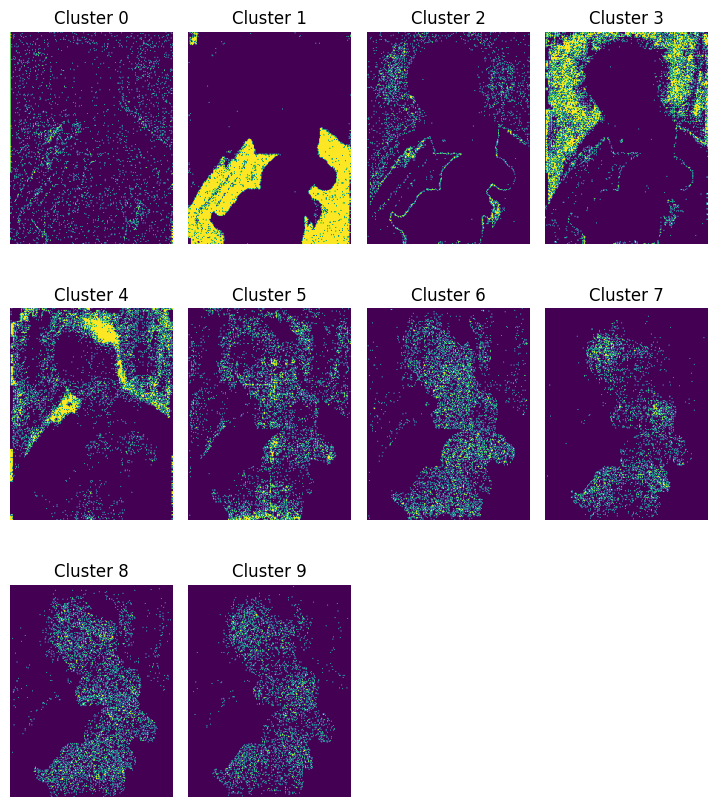

In [ ]:
label_masks = get_label_masks(e_xy, labels)

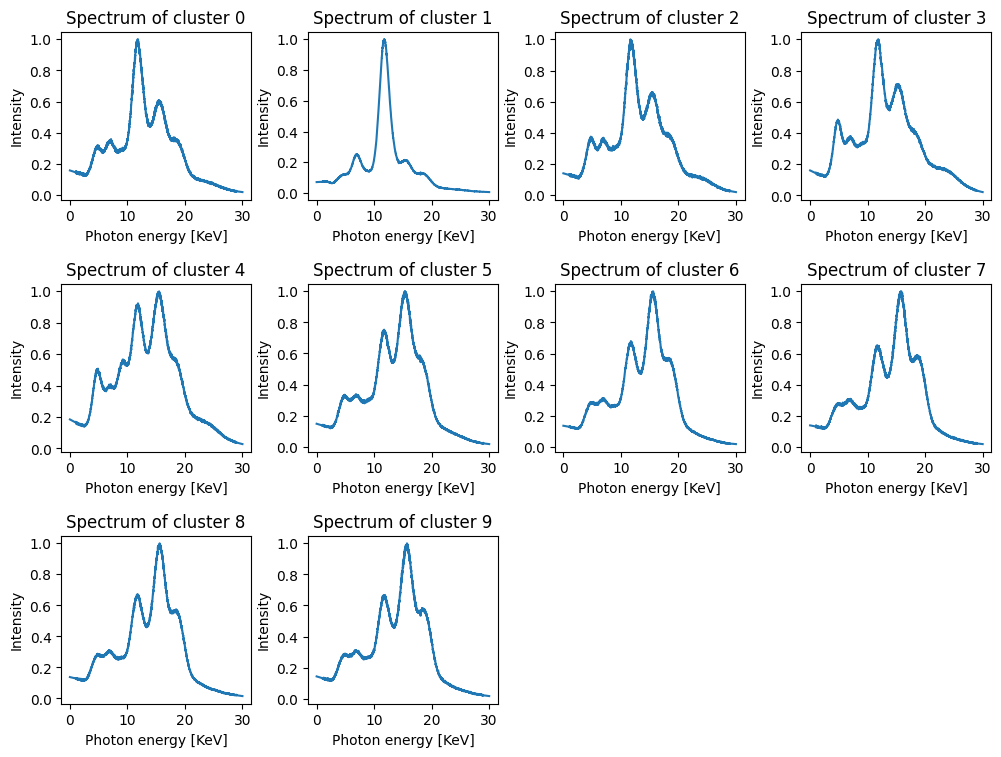

In [ ]:
plot_clustered_spectra(e_xy, label_masks, labels, peaks_sobieski, energies_sobieski)

In [ ]:
import random
import torch
import torch.nn as nn
from torch.nn import AvgPool2d

class VisionTransformer(nn.Module):
    def __init__(self, input_size, patch_size, embed_dim, num_heads, num_classes, num_layers, hidden_dim, dropout_rate):
        super(VisionTransformer, self).__init__()
        num_patches = input_size // patch_size
        self.patch_embed = nn.Conv1d(1, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout_rate)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, hidden_dim, dropout_rate) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim * num_patches, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.dropout(x + self.pos_embed)
        for i, block in enumerate(self.transformer_blocks):
            x = block(x)
        x = self.norm(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout_rate):
        super(TransformerBlock, self).__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        global attention_weights
        attn_output, attn_weights = self.attention(*([self.norm1(x)] * 3), need_weights=True)
        attention_weights = attn_weights
        x = x + attn_output
        x = x + self.feedforward(self.norm2(x))

        return x


input_size = 4096
patch_size = 16
embed_dim = 16
num_heads = 8
num_classes = 20
num_layers = 6
hidden_dim = 4 * embed_dim
dropout_rate = 0.1

model = VisionTransformer(input_size, patch_size, embed_dim, num_heads, num_classes, num_layers, hidden_dim, dropout_rate)
model.load_state_dict(torch.load("vit_equal_classes.pt", map_location=torch.device('cpu')))
model.eval()

VisionTransformer(
  (patch_embed): Conv1d(1, 16, kernel_size=(16,), stride=(16,), bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
      )
      (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=64, out_features=16, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=4096, out_features=20, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
peaks_sobieski = [817, 1016,1347, 1598]
energies_sobieski = [6.405, 8.046, 10.551, 12.614]

peaks_gasecki=[1360, 1623]
energies_gasecki=[10.551, 12.614]

peaks_matka_boska=[720, 985, 1594, 2068]
energies_matka_boska=[3.692, 5.088, 8.046, 10.551]

element_probabilities = np.zeros((20, *label_masks[0].shape))

e_xy = matka_boska_e_xy
peaks = peaks_matka_boska
energies = energies_matka_boska

model.to("cuda")

for i, mask in label_masks.items():
    energy = e_xy * mask[:, :, np.newaxis]
    channel_energies, spectrum_acc = get_processed_spectrum(energy, peaks, energies)

    spectrum_acc = spectrum_acc / spectrum_acc.max()

    y_pred = model(torch.tensor(spectrum_acc.reshape(1, 1, 4096)).float().to("cuda"))[0].to("cpu").detach().numpy()

    for j in range(len(y_pred)):
        element_probabilities[j] += mask * y_pred[j]


NameError: ignored

In [ ]:
num2elem = dict()
num2elem.update({
    0: "K"
    , 1:"Ca"
    , 2: "Ti"
    , 3: "V"
    , 4: "Cr"
    , 5: "Mn"
    , 6: "Fe"
    , 7: "Co"
    , 8: "Ni"
    , 9: "Cu"
    , 10: "Zn"
    , 11: "As"
    , 12: "Se"
    , 13: "Cd"
    , 14: "Sn"
    , 15: "Sb"
    , 16: "Au"
    , 17: "Hg"
    , 18: "Pb"
    , 19: "Bi"
})

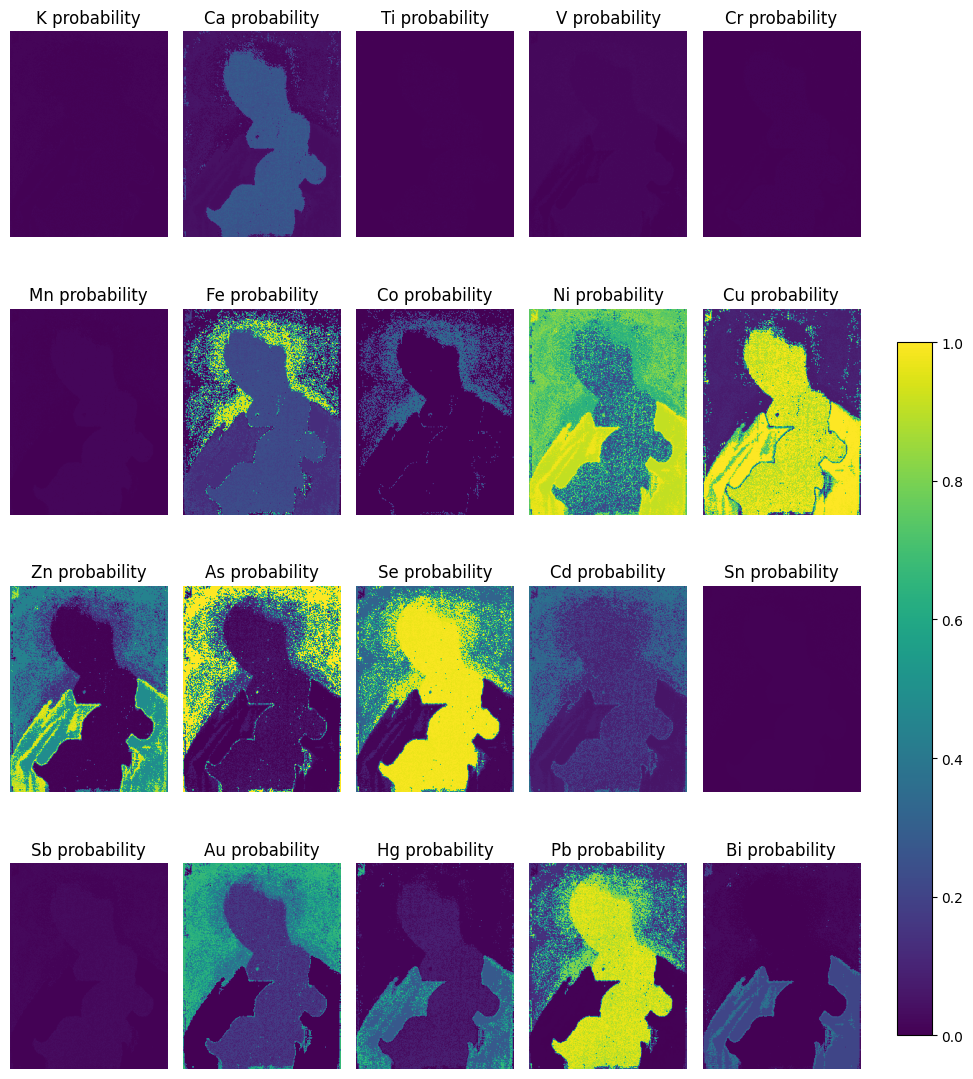

In [ ]:

grid_size = int(np.ceil(np.sqrt(len(element_probabilities))))
fig, ax = plt.subplots(grid_size, grid_size, figsize=(12,18))
plt.subplots_adjust(wspace=0.1, hspace=-0.0)
for i in range(grid_size):
    for j in range(grid_size):
        element_idx = i * grid_size + j
        if len(element_probabilities) > i * grid_size + j:
            temp = element_probabilities[element_idx]
            im = ax[i][j].imshow(temp, vmin=0, vmax=1, cmap='viridis')
            ax[i][j].set_title(f'{num2elem[element_idx]} probability')
            ax[i][j].axis('off')
        else:
            fig.delaxes(ax[i][j])
            axes_flat = ax.flatten()  # Flatten the 2D array of subplots

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, shrink=0.5, location = 'right')
fig.savefig("prediction_on_clusters_matka_boska.svg", bbox_inches='tight', pad_inches=0.1)


In [ ]:
def get_processed_spectrum_v2(spectrum_acc, peaks, energies, min_energy=0, max_energy=30
               , energy_margin=1, target_length=4096, points_to_extrapolate_count=100):

    correction_coefficients = np.polyfit(peaks, energies, 1)
    channel_energies = np.poly1d(correction_coefficients)(np.arange(len(spectrum_acc)))

    # Fit spectrum in range [min_energy, max_energy]
    mask = (channel_energies >= min_energy) & (channel_energies <= max_energy)
    channel_energies_mapped = channel_energies[mask]
    spectrum_acc_mapped = spectrum_acc[mask]

    # Mask edges of spectrum by energy_margin, as they have lots of noise
    energy_margin = (channel_energies_mapped < (channel_energies_mapped[0] + energy_margin)) | (channel_energies_mapped > channel_energies_mapped[-1] - energy_margin)
    spectrum_acc_masked = spectrum_acc_mapped.copy()
    spectrum_acc_masked[energy_margin] = 0

    # Padd spectrum to the right to make sure that it fills entire energy range [min_energy, max_energy]
    step_size = channel_energies_mapped[1] - channel_energies_mapped[0]
    step_count = int((max_energy - channel_energies_mapped[-1]) // step_size)
    channel_energies_extrapolated = np.concatenate((channel_energies_mapped, np.linspace(channel_energies_mapped[-1], max_energy, step_count)))
    spectrum_acc_padded = np.concatenate((spectrum_acc_masked, np.zeros(step_count)))

    # Interpolate to achieve target_length, so it could be processed by neural network
    min_energy = channel_energies_extrapolated[0]
    max_energy = channel_energies_extrapolated[-1]
    channel_energies_interpolated = interp1d(channel_energies_extrapolated, channel_energies_extrapolated, fill_value="extrapolate")(np.linspace(min_energy, max_energy, target_length))
    spectrum_acc_interpolated = interp1d(channel_energies_extrapolated, spectrum_acc_padded, fill_value="extrapolate")(np.linspace(min_energy, max_energy, target_length))



    return channel_energies_interpolated, spectrum_acc_interpolated

In [ ]:
e_xy = gasecki_e_xy
peaks = peaks_gasecki
energies = energies_gasecki

chunk_size = 1
num_chunks_y = e_xy.shape[0] // chunk_size
num_chunks_x = e_xy.shape[1] // chunk_size

averages = np.zeros((num_chunks_y, num_chunks_x, e_xy.shape[-1]))

for i in range(num_chunks_y):
    for j in range(num_chunks_x):
        chunk = e_xy[i*chunk_size:(i+1)*chunk_size, j*chunk_size:(j+1)*chunk_size, :]
        averages[i, j] = np.mean(chunk, axis=(0, 1))

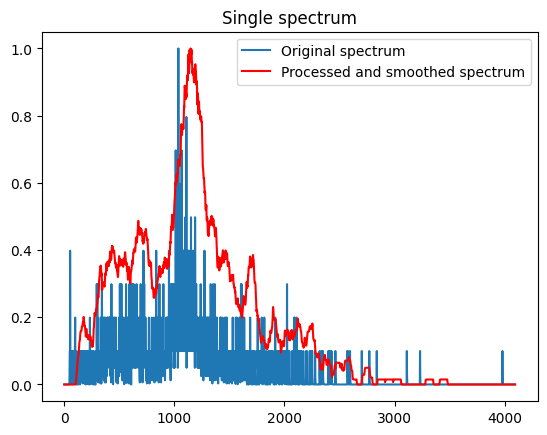

In [ ]:
from scipy.signal import savgol_filter

channel_energies, spectrum_acc = get_processed_spectrum_v2(averages[2][2], peaks, energies)
temp = savgol_filter(spectrum_acc, 71, 1)
temp = temp / np.max(temp)

plt.plot(averages[2][2] / np.max(averages[2][2]), label="Original spectrum")
plt.plot(temp, color="red", label="Processed and smoothed spectrum")
plt.legend(loc="upper right")
plt.title("Single spectrum")
plt.savefig("spectrum_5x5.svg")

In [ ]:
from tqdm import tqdm

element_probabilities = np.zeros((20, *averages.shape[:-1]))
model.to("cuda")

for i in tqdm(range(len(averages))):
    for j in range(len(averages[0])):
        X = savgol_filter(averages[i, j], 41, 1)
        channel_energies, X = get_processed_spectrum_v2(X, peaks, energies)
        X = X / np.max(X)

        y_pred = model(torch.tensor(X.reshape(1, 1, 4096)).to("cuda").float())[0].to("cpu").detach().numpy()
        for k, probability in enumerate(y_pred):
            element_probabilities[k, i, j] = probability


100%|██████████| 316/316 [13:03<00:00,  2.48s/it]


In [ ]:
print(element_probabilities[0])

[[0.0091787  0.04260602 0.00290785 ... 0.00120566 0.02882664 0.00462303]
 [0.34457177 0.01073529 0.00832806 ... 0.00895295 0.00555424 0.00930564]
 [0.0013891  0.00316588 0.01582225 ... 0.01326055 0.00546129 0.0022494 ]
 ...
 [0.00419456 0.00413221 0.00491056 ... 0.01004991 0.02093058 0.02093058]
 [0.0051111  0.00304419 0.01446147 ... 0.01295407 0.02492906 0.02492906]
 [0.00386819 0.00313676 0.00359823 ... 0.03304194 0.00070545 0.00070545]]


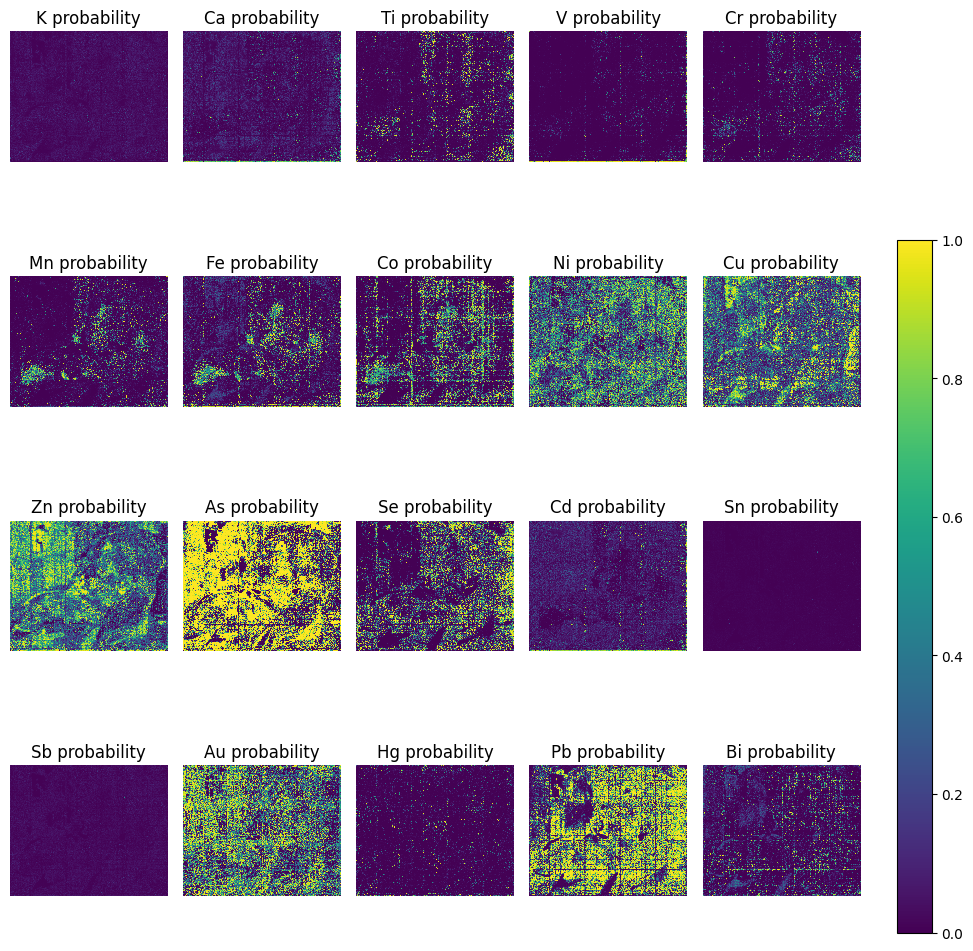

In [ ]:

grid_size = int(np.ceil(np.sqrt(20)))
fig, ax = plt.subplots(grid_size, grid_size, figsize=(12,18))
plt.subplots_adjust(wspace=0.1, hspace=-0.4)
for i in range(grid_size):
    for j in range(grid_size):
        element_idx = i * grid_size + j
        if 20 > i * grid_size + j:
            temp = element_probabilities[element_idx]
            im = ax[i][j].imshow(temp, vmin=0, vmax=1, cmap='viridis', interpolation="nearest")
            ax[i][j].set_title(f'{num2elem[element_idx]} probability')
            ax[i][j].axis('off')
        else:
            fig.delaxes(ax[i][j])
            axes_flat = ax.flatten()  # Flatten the 2D array of subplots

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, shrink=0.5, location = 'right')
fig.savefig("prediction_on_single_spectrum_gasecki.svg", bbox_inches='tight', pad_inches=0.1)